Binary Image Classifier Fine Tuned

In [1]:
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
from google.colab import files
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow_datasets as tfds
from zipfile import ZipFile
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
filename = "/content/gdrive/MyDrive/emotion_data_happy_sad.zip"
with ZipFile(filename, "r",) as zip:
  zip.extractall()

train_dir = '/content/emotion_data_happy_sad/train'
validation_dir = '/content/emotion_data_happy_sad/valid'
test_dir = '/content/emotion_data_happy_sad/test'

BATCH_SIZE = 20
IMG_SIZE = (48, 48)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=False,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                           )

Found 12045 files belonging to 2 classes.
Found 2821 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [3]:

# class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [4]:
for image, _ in train_dataset.take(1):
  print(type(image))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [6]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./255)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0001,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00015,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)
callbacks = [
    early_stopping,
    lr_scheduler,
]

In [8]:
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1, 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(48, 48, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.5)(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512,'sigmoid')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 48, 48, 3)         0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 48, 48, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 48, 48, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0     

In [10]:
#model.evaluate(validation_dataset)

In [11]:
#base_model.trainable = False
#initial_epochs = 15
#total_epochs = 30
#history = model.fit(train_dataset,
#                    epochs=initial_epochs,
#                    callbacks=callbacks,
#                    validation_data=validation_dataset)

In [12]:
def plot_single_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()
def plot_histories(histories):
  acc = []
  val_acc = []
  loss = []
  val_loss = []
  for history in histories:
    acc = acc + history.history['accuracy']
    val_acc = val_acc +history.history['val_accuracy']
    loss = loss + history.history['loss']
    val_loss = val_loss + history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [13]:
def fine_tune(model=model, total_epochs = 10, learning_rate=.0001, epoch_history = None):
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate),
              metrics=['accuracy'])
  history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=epoch_history.epoch[-1],
                         callbacks=callbacks,
                         validation_data=validation_dataset)
  return history_fine

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Epoch 1/5
603/603 [==============================] - 12s 17ms/step - loss: 0.7229 - accuracy: 0.5658 - val_loss: 0.6540 - val_accuracy: 0.6140 - lr: 1.0000e-04
Epoch 2/5
603/603 [==============================] - 10s 16ms/step - loss: 0.6952 - accuracy: 0.5871 - val_loss: 0.6459 - val_accuracy: 0.6172 - lr: 1.0000e-04
Epoch 3/5
603/603 [==============================] - 10s 16ms/step - loss: 0.6804 - accuracy: 0.6014 - val_loss: 0.6380 - val_accuracy: 0.6292 - lr: 1.0000e-04
Epoch 4/5
603/603 [==============================] - 10s 16ms/step - loss: 0.6743 - accuracy: 0.6050 - val_loss: 0.6336 - val_accuracy: 0.6356 - lr: 1.0000e-04
Epoch 5/5
603/603 [==============================] - 10s 16ms/step - loss: 0.6729 - accuracy: 0.6152 - val_loss: 0.6288 - val_accuracy: 0.6388 - lr: 1.0000e-04


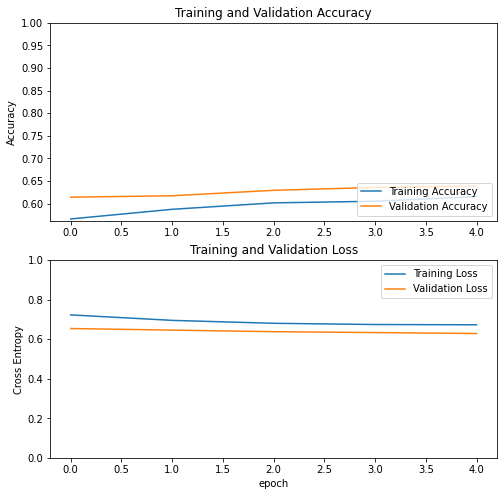

In [15]:
initial_epochs = 5
#total_epochs = 30

base_model.trainable = True;
for layer in base_model.layers:
  layer.trainable = False;


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks=callbacks,
                    validation_data=validation_dataset)
plot_single_history(history)

In [16]:
type(history.history['accuracy'])

list

Epoch 5/9
603/603 [==============================] - 17s 25ms/step - loss: 0.6451 - accuracy: 0.6451 - val_loss: 0.5797 - val_accuracy: 0.6824 - lr: 5.0000e-04
Epoch 6/9
603/603 [==============================] - 14s 24ms/step - loss: 0.6140 - accuracy: 0.6675 - val_loss: 0.5591 - val_accuracy: 0.6976 - lr: 5.0000e-04
Epoch 7/9
603/603 [==============================] - 14s 24ms/step - loss: 0.5905 - accuracy: 0.6919 - val_loss: 0.5606 - val_accuracy: 0.7097 - lr: 5.0000e-04
Epoch 8/9
603/603 [==============================] - 14s 24ms/step - loss: 0.5826 - accuracy: 0.6918 - val_loss: 0.5442 - val_accuracy: 0.7192 - lr: 5.0000e-04
Epoch 9/9
603/603 [==============================] - 14s 24ms/step - loss: 0.5753 - accuracy: 0.6999 - val_loss: 0.5349 - val_accuracy: 0.7281 - lr: 5.0000e-04


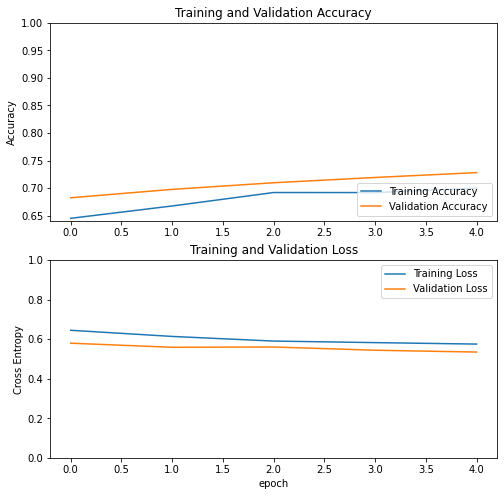

Epoch 9/13
603/603 [==============================] - 17s 26ms/step - loss: 0.5551 - accuracy: 0.7158 - val_loss: 0.5175 - val_accuracy: 0.7416 - lr: 1.0000e-04
Epoch 10/13
603/603 [==============================] - 15s 25ms/step - loss: 0.5368 - accuracy: 0.7306 - val_loss: 0.5336 - val_accuracy: 0.7168 - lr: 1.0000e-04
Epoch 11/13
603/603 [==============================] - 15s 25ms/step - loss: 0.5115 - accuracy: 0.7533 - val_loss: 0.4611 - val_accuracy: 0.7745 - lr: 1.0000e-04
Epoch 12/13
603/603 [==============================] - 15s 25ms/step - loss: 0.4900 - accuracy: 0.7647 - val_loss: 0.4568 - val_accuracy: 0.7777 - lr: 1.0000e-04
Epoch 13/13
603/603 [==============================] - 15s 25ms/step - loss: 0.4748 - accuracy: 0.7705 - val_loss: 0.4277 - val_accuracy: 0.8015 - lr: 1.0000e-04


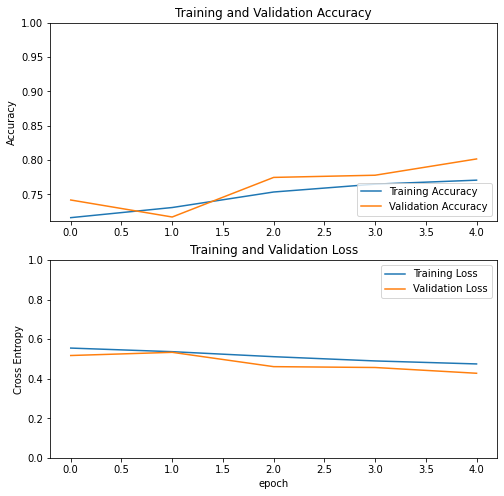

Epoch 13/18
603/603 [==============================] - 17s 26ms/step - loss: 0.4576 - accuracy: 0.7846 - val_loss: 0.3586 - val_accuracy: 0.8387 - lr: 5.0000e-05
Epoch 14/18
603/603 [==============================] - 16s 26ms/step - loss: 0.3970 - accuracy: 0.8266 - val_loss: 0.3847 - val_accuracy: 0.8213 - lr: 5.0000e-05
Epoch 15/18
603/603 [==============================] - 16s 26ms/step - loss: 0.3666 - accuracy: 0.8387 - val_loss: 0.3020 - val_accuracy: 0.8742 - lr: 5.0000e-05
Epoch 16/18
603/603 [==============================] - 16s 26ms/step - loss: 0.3472 - accuracy: 0.8508 - val_loss: 0.2883 - val_accuracy: 0.8791 - lr: 5.0000e-05
Epoch 17/18
603/603 [==============================] - 16s 26ms/step - loss: 0.3233 - accuracy: 0.8624 - val_loss: 0.2807 - val_accuracy: 0.8848 - lr: 5.0000e-05
Epoch 18/18
603/603 [==============================] - 16s 26ms/step - loss: 0.3112 - accuracy: 0.8689 - val_loss: 0.2737 - val_accuracy: 0.8873 - lr: 5.0000e-05


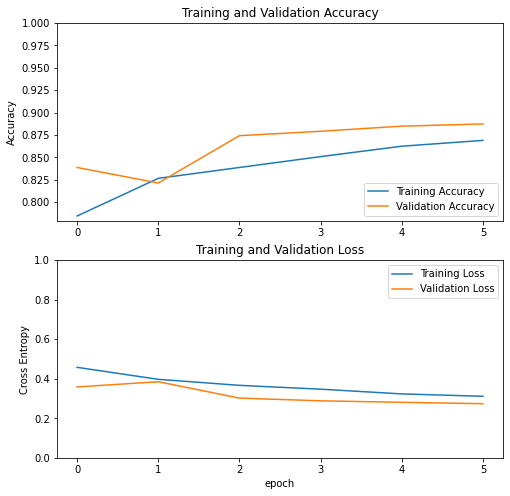

Epoch 18/24
603/603 [==============================] - 19s 29ms/step - loss: 0.2841 - accuracy: 0.8813 - val_loss: 0.2573 - val_accuracy: 0.9011 - lr: 1.0000e-05
Epoch 19/24
603/603 [==============================] - 17s 29ms/step - loss: 0.2683 - accuracy: 0.8902 - val_loss: 0.2443 - val_accuracy: 0.9054 - lr: 1.0000e-05
Epoch 20/24
603/603 [==============================] - 17s 28ms/step - loss: 0.2595 - accuracy: 0.8936 - val_loss: 0.2457 - val_accuracy: 0.9054 - lr: 1.0000e-05
Epoch 21/24
603/603 [==============================] - 17s 28ms/step - loss: 0.2526 - accuracy: 0.8953 - val_loss: 0.2326 - val_accuracy: 0.9117 - lr: 1.0000e-05
Epoch 22/24
603/603 [==============================] - 17s 29ms/step - loss: 0.2422 - accuracy: 0.8994 - val_loss: 0.2491 - val_accuracy: 0.9000 - lr: 1.0000e-05
Epoch 23/24
603/603 [==============================] - 17s 29ms/step - loss: 0.2378 - accuracy: 0.9062 - val_loss: 0.2524 - val_accuracy: 0.8983 - lr: 1.0000e-05
Epoch 24/24
603/603 [=======

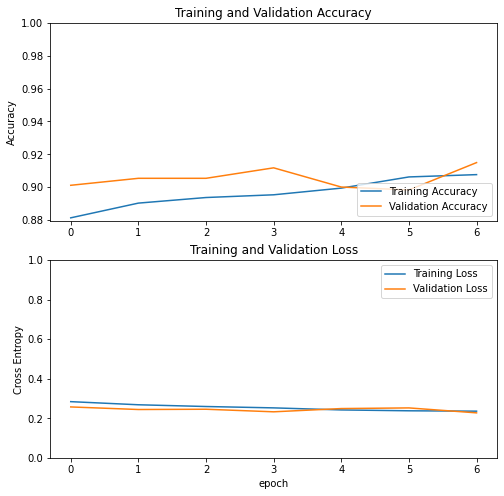

Epoch 24/31
603/603 [==============================] - 21s 32ms/step - loss: 0.2286 - accuracy: 0.9099 - val_loss: 0.2366 - val_accuracy: 0.9085 - lr: 1.0000e-05
Epoch 25/31
603/603 [==============================] - 19s 31ms/step - loss: 0.2164 - accuracy: 0.9129 - val_loss: 0.2248 - val_accuracy: 0.9146 - lr: 1.0000e-05
Epoch 26/31
603/603 [==============================] - 19s 31ms/step - loss: 0.2202 - accuracy: 0.9113 - val_loss: 0.2321 - val_accuracy: 0.9132 - lr: 1.0000e-05
Epoch 27/31
603/603 [==============================] - 19s 31ms/step - loss: 0.2083 - accuracy: 0.9152 - val_loss: 0.2300 - val_accuracy: 0.9149 - lr: 1.0000e-05
Epoch 28/31
603/603 [==============================] - 19s 31ms/step - loss: 0.2004 - accuracy: 0.9200 - val_loss: 0.2204 - val_accuracy: 0.9167 - lr: 1.0000e-05
Epoch 29/31
603/603 [==============================] - 19s 31ms/step - loss: 0.2034 - accuracy: 0.9168 - val_loss: 0.2193 - val_accuracy: 0.9160 - lr: 1.0000e-05
Epoch 30/31
603/603 [=======

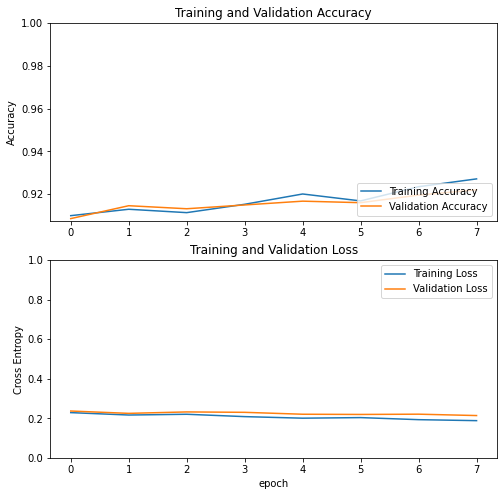

In [17]:
stages = [
  base_model.layers[:4],
  base_model.layers[:7],
  base_model.layers[:11],
  base_model.layers[:15],
  base_model.layers[:19]
]
epochs_list = [4,4,5,6,7]
lrs = [.0005, .0001, .00005, .00001, .00001]
i = 0

epochs = initial_epochs
history_fine = history
histories = [history]
for stage in stages:
  for layer in stage:
    layer.trainable = True
  epochs = epochs + epochs_list[i]
  lr = lrs[i]
  i = i+1
  history_fine = fine_tune(model=model, total_epochs = epochs, learning_rate=lr, epoch_history = history_fine)
  
  histories.append(history_fine)
  plot_single_history(history_fine)




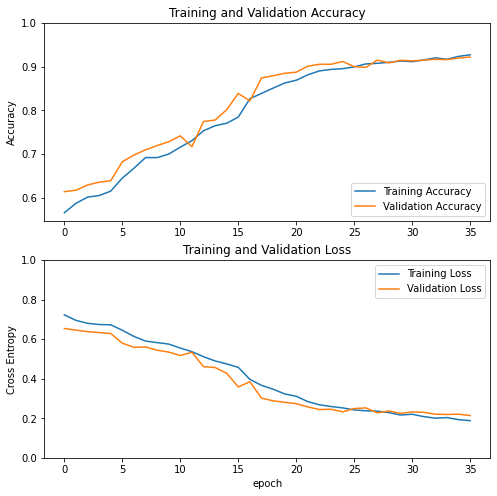

In [18]:
plot_histories(histories)

In [19]:
results = model.evaluate(test_dataset)
if (results[1] >= .92):
  print("model saved")
  model.save("/content/gdrive/MyDrive/Colab Notebooks/models/vgg_emotion_binary_fine_tune_save1", save_format = 'h5')

10/10 [==============================] - 0s 13ms/step - loss: 0.2306 - accuracy: 0.9200
model saved


In [20]:
test_batchs = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory='/content/emotion_data_happy_sad/test',
    target_size=(48,48),
    batch_size=20,
    shuffle=False
)

Found 200 images belonging to 2 classes.


In [21]:
import sklearn

test_labels = test_batchs.classes
predictions=model.predict(x=test_dataset,verbose=0)
cm = confusion_matrix(y_true=test_labels,y_pred=predictions>0.28)
cm2 = confusion_matrix(y_true=test_labels,y_pred=predictions>0.3)
cm3 = confusion_matrix(y_true=test_labels,y_pred=predictions>.6)
mat = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.array(['happy','sad']))
mat2 = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=np.array(['happy','sad']))
mat3 = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=np.array(['happy','sad']))

In [22]:
def find_Threshold_sad():
  idealThreshold = 0
  highestLength = 0
  for i in range(1,1000):
    threshold = i/1000
    cm = confusion_matrix(y_true=test_labels,y_pred=predictions>threshold)
    L = abs(complex(cm[0][0],cm[1][1]))
    if (L > highestLength and cm[0][0]>cm[1][1]):
      highestLength = L
      idealThreshold = threshold
  return idealThreshold
def find_Threshold_happy():
  idealThreshold = 0
  highestLength = 0
  for i in range(1,1000):
    threshold = i/1000
    cm = confusion_matrix(y_true=test_labels,y_pred=predictions>threshold)
    L = abs(complex(cm[0][0],cm[1][1]))
    if (L > highestLength and cm[0][0]<cm[1][1]):
      highestLength = L
      idealThreshold = threshold
  return idealThreshold
def find_Threshold_equal():
  idealThreshold = 0
  highestLength = 0
  lowestDifference = 100
  for i in range(1,1000):
    threshold = i/1000
    cm = confusion_matrix(y_true=test_labels,y_pred=predictions>threshold)
    L = abs(complex(cm[0][0],cm[1][1]))
    difference = abs(cm[0][0] - cm[1][1])
    if (difference < lowestDifference):
      highestLength = L
      lowestDifference = difference
      idealThreshold = threshold
  return idealThreshold

In [23]:
ht = find_Threshold_happy()
print(ht)
cm_happy = confusion_matrix(y_true=test_labels,y_pred=predictions>ht)
mat_happy = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_happy,display_labels=np.array(['happy','sad']))

st = find_Threshold_sad()
print(st)
cm_sad = confusion_matrix(y_true=test_labels,y_pred=predictions>st)
mat_sad = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_sad,display_labels=np.array(['happy','sad']))

et = find_Threshold_equal()
print(et)
cm_equal = confusion_matrix(y_true=test_labels,y_pred=predictions>et)


#hi
mat_equal = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm_equal,display_labels=np.array(['happy','sad']))

0.277
0.574
0.436


In [24]:

fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_labels,predictions)
roc1 = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)


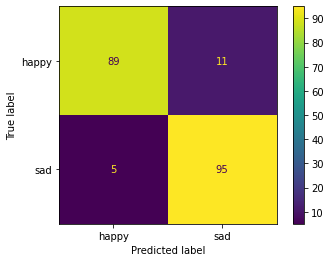

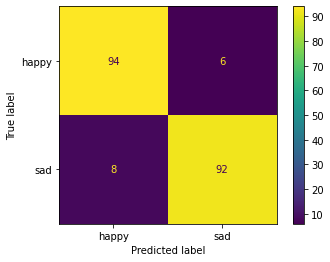

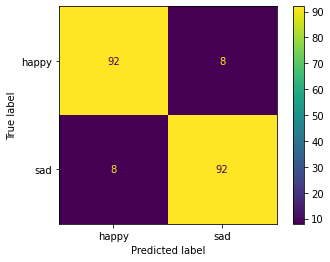

In [25]:
mat_happy.plot()
mat_sad.plot()
mat_equal.plot()

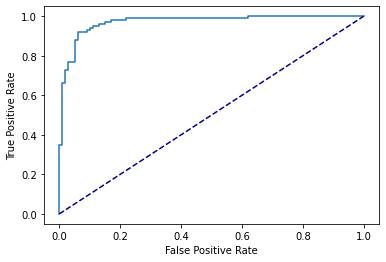

In [26]:
roc1.plot()
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

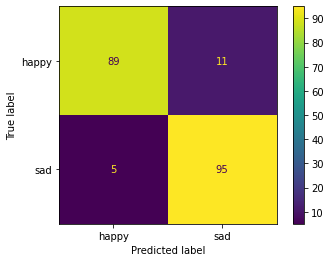

In [27]:
mat2.plot()

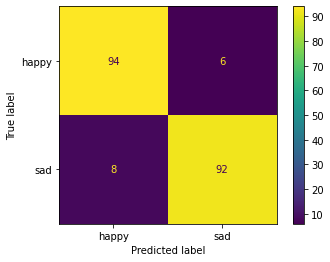

In [28]:
mat3.plot()

In [29]:

for i in range (len(predictions)):
  print(predictions[i], test_labels[i])

[0.00112227] 0
[0.00123421] 0
[0.00037351] 0
[0.00182507] 0
[0.00198419] 0
[0.00180716] 0
[0.00292605] 0
[0.00220216] 0
[0.00046443] 0
[0.01076108] 0
[0.00592658] 0
[0.0033103] 0
[0.08190769] 0
[0.9578384] 0
[0.00045489] 0
[0.00104404] 0
[0.13796914] 0
[0.00049756] 0
[0.00047957] 0
[0.00123588] 0
[0.00099572] 0
[0.00122848] 0
[0.00029526] 0
[0.00082672] 0
[0.00365247] 0
[0.00048204] 0
[0.00076252] 0
[0.04737353] 0
[0.98589617] 0
[0.00054611] 0
[0.00304805] 0
[0.00063462] 0
[0.00020483] 0
[0.00100598] 0
[0.00193774] 0
[0.01869511] 0
[0.00271662] 0
[0.06262966] 0
[0.00060208] 0
[0.00055328] 0
[0.00288655] 0
[0.43527937] 0
[0.0014206] 0
[0.90442383] 0
[0.09367522] 0
[0.00236879] 0
[0.00064559] 0
[0.01413295] 0
[0.00301863] 0
[0.7695275] 0
[0.00433644] 0
[0.01249519] 0
[0.00076654] 0
[0.00080815] 0
[0.23425129] 0
[0.00015557] 0
[0.57335705] 0
[0.00054074] 0
[0.00054708] 0
[0.04483903] 0
[0.0006738] 0
[0.0092416] 0
[0.00397104] 0
[0.00120521] 0
[0.0004445] 0
[0.00039704] 0
[0.11409884] 0
[0